# 2.6 Q学習で迷路を攻略
- 基本
  - 方策
    - エージェントがどのように行動するのかを定めたルールのこと
    - 通常、PolicyのPからπ(s, a)と表される
    - sは状態、aは行動を表す
    - つまり、状態sのときに行動aを採用する確率はパラメータθで決まる方策πに従う
  - パラメータ
    - 通常θで表される
    - 関数の場合は関数内のパラメータ、ニューラルネットワークの場合は重みなどに対応する
    - 今回のような表形式の場合は、状態sのときに行動aを採用する確率へと変換される値を示す

## 使用するパッケージの宣言

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

DEBUG = True

## 初期位置での迷路の様子

/home/kunimune/.pyenv/versions/3.4.3/lib/python3.4/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


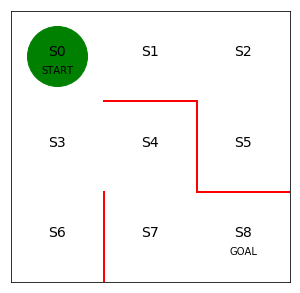

In [ ]:
# 図を描く大きさと、図の変数名を宣言
fig = plt.figure(figsize=(5, 5))
ax = plt.gca()

# 赤い壁を描く
plt.plot([1, 1], [0, 1], color='red', linewidth=2)
plt.plot([1, 2], [2, 2], color='red', linewidth=2)
plt.plot([2, 2], [2, 1], color='red', linewidth=2)
plt.plot([2, 3], [1, 1], color='red', linewidth=2)

# 状態を示す文字S0～S8を描く
plt.text(0.5, 2.5, 'S0', size=14, ha='center')
plt.text(1.5, 2.5, 'S1', size=14, ha='center')
plt.text(2.5, 2.5, 'S2', size=14, ha='center')
plt.text(0.5, 1.5, 'S3', size=14, ha='center')
plt.text(1.5, 1.5, 'S4', size=14, ha='center')
plt.text(2.5, 1.5, 'S5', size=14, ha='center')
plt.text(0.5, 0.5, 'S6', size=14, ha='center')
plt.text(1.5, 0.5, 'S7', size=14, ha='center')
plt.text(2.5, 0.5, 'S8', size=14, ha='center')
plt.text(0.5, 2.3, 'START', ha='center')
plt.text(2.5, 0.3, 'GOAL', ha='center')

# 描画範囲の設定と目盛りを消す設定
ax.set_xlim(0, 3)
ax.set_ylim(0, 3)
plt.tick_params(axis='both', which='both', bottom='off', top='off',
                labelbottom='off', right='off', left='off', labelleft='off')

# 現在地S0に緑丸を描画する
line, = ax.plot([0.5], [2.5], marker="o", color='g', markersize=60)

## 初期の方策を決定するパラメータtheta_0を設定
- 行は状態0～7、列は移動方向で↑、→、↓、←を表す
- 例えば S0 の場合、↑←は壁、→↓にしか行けない

In [ ]:
#                    ↑      →      ↓      ←
theta_0 = np.array([[np.nan, 1,      1,      np.nan],  # s0
                    [np.nan, 1,      np.nan, 1     ],  # s1
                    [np.nan, np.nan, 1,      1     ],  # s2
                    [1,      1,      1,      np.nan],  # s3
                    [np.nan, np.nan, 1,      1     ],  # s4
                    [1,      np.nan, np.nan, np.nan],  # s5
                    [1,      np.nan, np.nan, np.nan],  # s6
                    [1,      1,      np.nan, np.nan],  # s7、※s8はゴールなので、方策はなし
                    ])
print( "theta_0.shape=", theta_0.shape )

theta_0.shape= (8, 4)


## 方策パラメータtheta_0をランダム方策piに変換する関数の定義
- nan は 0 とみなし、方策パラメータtheta_0を確率に変換する

In [ ]:
def simple_convert_into_pi_from_theta(theta):
    '''単純に割合を計算する'''

    [m, n] = theta.shape  # thetaの行列サイズを取得
    pi = np.zeros((m, n))
    for i in range(0, m):
        pi[i, :] = theta[i, :] / np.nansum(theta[i, :])  # 割合の計算

    pi = np.nan_to_num(pi)  # nanを0に変換

    return pi

# ランダム行動方策pi_0を求める
pi_0 = simple_convert_into_pi_from_theta(theta_0)
print( pi_0 )

[[0.         0.5        0.5        0.        ]
 [0.         0.5        0.         0.5       ]
 [0.         0.         0.5        0.5       ]
 [0.33333333 0.33333333 0.33333333 0.        ]
 [0.         0.         0.5        0.5       ]
 [1.         0.         0.         0.        ]
 [1.         0.         0.         0.        ]
 [0.5        0.5        0.         0.        ]]


## 初期の行動価値関数Qを設定

In [ ]:
if DEBUG:
    print( np.random.rand(8, 4) ) # 0～1の乱数で、8x4の行列を生成

[[0.50816453 0.3073579  0.63506625 0.64602663]
 [0.75290894 0.59379335 0.96557485 0.98104709]
 [0.95384759 0.02348001 0.22314892 0.85952052]
 [0.8299844  0.60647582 0.71758727 0.53696642]
 [0.72669787 0.62075415 0.85057822 0.65022602]
 [0.69320855 0.6076415  0.47019644 0.85992366]
 [0.70272637 0.91953423 0.94406446 0.63311221]
 [0.73151836 0.05450336 0.93259328 0.39240107]]


In [ ]:
[a, b] = theta_0.shape  # 行と列の数をa, bに格納
Q = np.random.rand(a, b) * theta_0 * 0.1
# *theta0をすることで要素ごとに掛け算をし、Qの壁方向の値がnanになる
print( Q )

[[       nan 0.02896363 0.03363906        nan]
 [       nan 0.07343952        nan 0.07391754]
 [       nan        nan 0.0078599  0.00676269]
 [0.04504441 0.05778568 0.01596591        nan]
 [       nan        nan 0.05210909 0.0876727 ]
 [0.09205729        nan        nan        nan]
 [0.01013489        nan        nan        nan]
 [0.03551252 0.04914539        nan        nan]]


## ε-greedy法を実装

In [ ]:
if DEBUG:
    # 乱数生成 (0～1の乱数を1個生成)
    print( np.random.rand() )
    
    # 指定したリストからランダムに選択
    direction = ["up", "right", "down", "left"]
    print( np.random.choice(direction   ) ) # デフォルトのサイズはNone、1つ取り出す
    print( np.random.choice(direction, 1) ) # サイズを指定した場合はリストが返る
    print( np.random.choice(direction, 2) )
    
    # pにリストを渡すことで取り出す値の頻度を変える ※pの値の合計は 1 になることに注意
    print( np.random.choice(direction, p=[0.9, 0.05, 0.03, 0.02]) )    

0.11757527107339028
right
['down']
['left' 'left']
up


### get_action()
- pi_0 は、アクションの確率であり、固定
  - →と↑しか行けない場合、0.5と0.5など
  - 壁は0なので、選ばれることはない
- Qテーブルの最大値を選択しているが、同じ値の場合に偏りはないか？

In [ ]:
def get_action(s, Q, epsilon, pi_0):
    direction = ["up", "right", "down", "left"]

    # 行動を決める (0～1の乱数を1個生成)
    if np.random.rand() < epsilon:
        # εの確率でランダムに動く
        next_direction = np.random.choice(direction, p=pi_0[s, :])
    else:
        # Qの最大値の行動を採用する
        next_direction = direction[np.nanargmax(Q[s, :])]

    # 行動をindexに
    if   next_direction == "up":
        action = 0
    elif next_direction == "right":
        action = 1
    elif next_direction == "down":
        action = 2
    elif next_direction == "left":
        action = 3

    return action

### get_s_next()
- 現在の状態と今回選択した行動から次の状態を取得する

In [ ]:
def get_s_next(s, a, Q, epsilon, pi_0):
    direction = ["up", "right", "down", "left"]
    next_direction = direction[a]  # 行動aの方向

    # 行動から次の状態を決める
    if next_direction == "up":
        s_next = s - 3  # 上に移動するときは状態の数字が3小さくなる
    elif next_direction == "right":
        s_next = s + 1  # 右に移動するときは状態の数字が1大きくなる
    elif next_direction == "down":
        s_next = s + 3  # 下に移動するときは状態の数字が3大きくなる
    elif next_direction == "left":
        s_next = s - 1  # 左に移動するときは状態の数字が1小さくなる

    return s_next

## Q学習による行動価値関数Qの更新
- 今回選択した行動を行動価値関数Qにフィードバック
- Q_learning()はQ学習のアルゴリズム
- 5-8.c と少し異なるが、考え方は同じ
- 2つのアルゴリズム、Sarsa と Q学習 があり、行動価値関数Qの更新式が異なる
- Sarsa：$Q(s_t, a_t) = Q(s_t, a_t) + η(R_{t+1} + γQ(s_{t+1}, a_{t+1}) - Q(s_t, a_t))$
- Q学習：$Q(s_t, a_t) = Q(s_t, a_t) + η(R_{t+1} + γmaxQ(s_{t+1}, a) - Q(s_t, a_t))$
- Sarsaの場合は、更新時に次の行動$a_{t+1}$を求め、行動価値関数Qの更新に使用する
- Q学習の場合は、状態$s_{t+1}$の行動価値関数の値のうち、最大のものを更新に使用する
- Sarsaは、Qの更新が$a_{t+1}$を求める方策に依存するという特徴があり、方策オン型と呼ぶ
- Q学習は、Qの更新が行動の決定方法(方策)に依存しない、これを方策オフ型と呼ぶ
- Q学習は、ε-greedy法のランダム性が更新式に入らない分、行動価値関数の収束がSarsaより早いという特徴がある

In [ ]:
def Q_learning(s, a, r, s_next, Q, eta, gamma):
    if s_next == 8:  # ゴールした場合
        Q[s, a] = Q[s, a] + eta * (r - Q[s, a])
    else:
        Q[s, a] = Q[s, a] + eta * (r + gamma * np.nanmax(Q[s_next, :]) - Q[s, a])

    return Q

## Q学習で迷路を解く関数の定義
- 状態と行動の履歴および更新したQを出力
- ややこしいループになっているが、単純にループ先頭でget_action()を実行すればいいと思う
- その場合、5-8.c と同じアルゴリズムとなる

In [ ]:
def goal_maze_ret_s_a_Q(Q, epsilon, eta, gamma, pi):
    s = 0  # スタート地点
    a = a_next = get_action(s, Q, epsilon, pi)  # 初期の行動選択 (0～3のいずれかを取得)
    s_a_history = [[0, np.nan]]  # エージェントの移動を記録するリスト

    while (1):  # ゴールするまでループ
        a = a_next  # 行動更新

        # 現在の状態（つまり一番最後なのでindex=-1）に行動を代入
        s_a_history[-1][1] = a

        # 次の状態を格納
        s_next = get_s_next(s, a, Q, epsilon, pi)

        # 次の状態を代入。行動はまだ分からないのでnanにしておく
        s_a_history.append([s_next, np.nan])

        # 報酬を与え,　次の行動を求めます
        if s_next == 8:
            r = 1  # ゴールにたどり着いたなら報酬を与える
            a_next = np.nan
        else:
            r = 0
            # 次の行動a_nextを求めます。
            a_next = get_action(s_next, Q, epsilon, pi)

        # 価値関数を更新
        Q = Q_learning(s, a, r, s_next, Q, eta, gamma)

        # 終了判定
        if s_next == 8:  # ゴール地点なら終了
            break
        else:
            s = s_next

    return [s_a_history, Q]

## Q学習で迷路を解く

In [ ]:
eta     = 0.1  # 学習率
gamma   = 0.9  # 時間割引率
epsilon = 0.5  # ε-greedy法の初期値
v = np.nanmax(Q, axis=1)  # 状態ごとに価値の最大値を求める
is_continue = True
episode = 1

V = []                          # エピソードごとの状態価値を格納する
V.append(np.nanmax(Q, axis=1))  # 状態ごとに行動価値の最大値を求める

while is_continue:  # is_continueがFalseになるまで繰り返す
    print("エピソード:" + str(episode))

    # ε-greedyの値を少しずつ小さくする
    epsilon = epsilon / 2

    # Q学習で迷路を解き、移動した履歴と更新したQを求める
    [s_a_history, Q] = goal_maze_ret_s_a_Q(Q, epsilon, eta, gamma, pi_0)

    # 状態価値の変化
    new_v = np.nanmax(Q, axis=1)  # 状態ごとに行動価値の最大値を求める
    print(np.sum(np.abs(new_v - v)))  # 状態価値関数の変化を出力
    v = new_v
    V.append(v)  # このエピソード終了時の状態価値関数を追加

    print("迷路を解くのにかかったステップ数は" + str(len(s_a_history) - 1) + "です")

    # 100エピソード繰り返す
    episode = episode + 1
    if episode > 100:
        break

エピソード:1
0.21940239090080627
迷路を解くのにかかったステップ数は360です
エピソード:2
0.09402393546884173
迷路を解くのにかかったステップ数は8です
エピソード:3
0.09275897355757762
迷路を解くのにかかったステップ数は8です
エピソード:4
0.0901956685074779
迷路を解くのにかかったステップ数は4です
エピソード:5
0.10260611082558951
迷路を解くのにかかったステップ数は28です
エピソード:6
0.08806028742663854
迷路を解くのにかかったステップ数は4です
エピソード:7
0.08717205732298107
迷路を解くのにかかったステップ数は4です
エピソード:8
0.08625437101189648
迷路を解くのにかかったステップ数は4です
エピソード:9
0.08529601271136142
迷路を解くのにかかったステップ数は4です
エピソード:10
0.08428676721627934
迷路を解くのにかかったステップ数は4です
エピソード:11
0.08321789926247154
迷路を解くのにかかったステップ数は4です
エピソード:12
0.0820824289192044
迷路を解くのにかかったステップ数は4です
エピソード:13
0.08087525295627056
迷路を解くのにかかったステップ数は4です
エピソード:14
0.07959315237400696
迷路を解くのにかかったステップ数は4です
エピソード:15
0.07823471820124228
迷路を解くのにかかったステップ数は4です
エピソード:16
0.07680022099339343
迷路を解くのにかかったステップ数は4です
エピソード:17
0.075291443976174
迷路を解くのにかかったステップ数は4です
エピソード:18
0.07371149528857117
迷路を解くのにかかったステップ数は4です
エピソード:19
0.07206461111955031
迷路を解くのにかかったステップ数は4です
エピソード:20
0.07035595856868335
迷路を解くのにかかったステップ数は4です
エピソード:21
0

## 状態価値の変化を可視化します
- 参考URL：[http://louistiao.me/posts/notebooks/embedding-matplotlib-animations-in-jupyter-notebooks/](http://louistiao.me/posts/notebooks/embedding-matplotlib-animations-in-jupyter-notebooks/)
- カラーマップのjet方式を採用している
- 状態価値Vが低いと濃い青色、高いと濃い赤色となる(茶色に見えるが、、、)

In [ ]:
from matplotlib import animation
from IPython.display import HTML
import matplotlib.cm as cm  # color map

def init():
    # 背景画像の初期化
    line.set_data([], [])
    return (line,)

def animate(i):
    # フレームごとの描画内容
    # 各マスに状態価値の大きさに基づく色付きの四角を描画
    line, = ax.plot([0.5], [2.5], marker="s",
                    color=cm.jet(V[i][0]), markersize=85)  # S0
    line, = ax.plot([1.5], [2.5], marker="s",
                    color=cm.jet(V[i][1]), markersize=85)  # S1
    line, = ax.plot([2.5], [2.5], marker="s",
                    color=cm.jet(V[i][2]), markersize=85)  # S2
    line, = ax.plot([0.5], [1.5], marker="s",
                    color=cm.jet(V[i][3]), markersize=85)  # S3
    line, = ax.plot([1.5], [1.5], marker="s",
                    color=cm.jet(V[i][4]), markersize=85)  # S4
    line, = ax.plot([2.5], [1.5], marker="s",
                    color=cm.jet(V[i][5]), markersize=85)  # S5
    line, = ax.plot([0.5], [0.5], marker="s",
                    color=cm.jet(V[i][6]), markersize=85)  # S6
    line, = ax.plot([1.5], [0.5], marker="s",
                    color=cm.jet(V[i][7]), markersize=85)  # S7
    line, = ax.plot([2.5], [0.5], marker="s",
                    color=cm.jet(1.0    ), markersize=85)  # S8
    return (line,)

#　初期化関数とフレームごとの描画関数を用いて動画を作成
anim = animation.FuncAnimation(
    fig, animate, init_func=init, frames=len(V), interval=200, repeat=False)

HTML(anim.to_jshtml())